In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from helpings import *

In [2]:
#########################################
# Data Loading
#########################################

image_dir = "/Users/aurelien/ML/ML_course-main/projects/project2/data/training/patches/images"
mask_dir = "/Users/aurelien/ML/ML_course-main/projects/project2/data/training/patches/groundtruth"

image_files = sorted(glob.glob(os.path.join(image_dir, "*.png")))
mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

# Load all images into memory (if dataset fits into memory)
# If not, consider using a tf.data pipeline with lazy loading.
images = [plt.imread(f) for f in image_files]  # shape ~ (256,256,3)
masks = [plt.imread(fm) for fm in mask_files]  # shape ~ (256,256), binary mask
images = np.stack(images, axis=0)
masks = np.stack(masks, axis=0)

# Ensure masks are binary 0/1
masks = (masks > 0.5).astype(np.float32)

print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Images shape: (2400, 256, 256, 3)
Masks shape: (2400, 256, 256)


In [3]:
#########################################
# Train/Val/Test Split
#########################################
trainval_images, test_images, trainval_masks, test_masks = train_test_split(
    images, masks, test_size=0.1, random_state=42
)
train_images, val_images, train_masks, val_masks = train_test_split(
    trainval_images, trainval_masks, test_size=0.2, random_state=42
)

print("Train Images Shape:", train_images.shape)
print("Train Masks Shape:", train_masks.shape)
print("Validation Images Shape:", val_images.shape)
print("Validation Masks Shape:", val_masks.shape)

Train Images Shape: (1728, 256, 256, 3)
Train Masks Shape: (1728, 256, 256)
Validation Images Shape: (432, 256, 256, 3)
Validation Masks Shape: (432, 256, 256)


In [ ]:
#########################################
# Hyperparameters
#########################################
input_shape = train_images.shape[1:]  # Dynamically get input shape
lr = 1e-4
patience = 5


batch = 32
n_layers = 4
epochs = 100
init_filters = 16
reg = 1e-6
d_out=0.1

model_256B32F16 = build_unet(input_shape=input_shape,num_layers=n_layers,initial_filters=init_filters,dropout_rate=d_out,l2_reg=reg)

# Compile the model
model_256B32F16.compile(optimizer=Adam(learning_rate=lr), 
              loss=combined_loss,
              metrics=["accuracy"])

# Summary
model_256B32F16.summary()

# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "model_256B32F16.h5", save_best_only=True, monitor="val_loss", mode="min"
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=patience, restore_best_weights=True, monitor="val_loss", mode="min"
)

history_256B32F16 = model_256B32F16.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=epochs,
    batch_size=batch,
    callbacks=[checkpoint_cb, earlystop_cb]
)

#Save the model
model_256B32F16.save("model_256B32F16.h5")

Model: "U-Net_256x256"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d_1[0][0]']            
                                                                                      

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


54/54 [==============================] - 178s 3s/step - loss: 0.7445 - accuracy: 0.7908 - val_loss: 0.7343 - val_accuracy: 0.7065
Epoch 3/100
54/54 [==============================] - 161s 3s/step - loss: 0.6824 - accuracy: 0.7993 - val_loss: 0.6929 - val_accuracy: 0.7219
Epoch 4/100
54/54 [==============================] - 164s 3s/step - loss: 0.5914 - accuracy: 0.8361 - val_loss: 0.5837 - val_accuracy: 0.8298
Epoch 5/100
54/54 [==============================] - 167s 3s/step - loss: 0.5190 - accuracy: 0.8655 - val_loss: 0.5196 - val_accuracy: 0.8544
Epoch 6/100
54/54 [==============================] - 168s 3s/step - loss: 0.4686 - accuracy: 0.8807 - val_loss: 0.4950 - val_accuracy: 0.8678
Epoch 7/100
54/54 [==============================] - 168s 3s/step - loss: 0.4314 - accuracy: 0.8914 - val_loss: 0.4533 - val_accuracy: 0.8882
Epoch 8/100
54/54 [==============================] - 169s 3s/step - loss: 0.4115 - accuracy: 0.8975 - val_loss: 0.4372 - val_accuracy: 0.8863
Epoch 9/100
54/54 

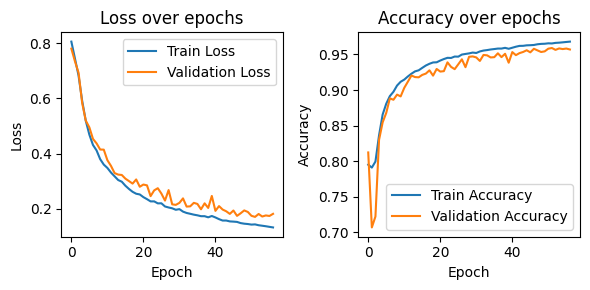

In [6]:
plot_training_history(history_256B32F16)

In [ ]:
#########################################
# Hyperparameters
#########################################
input_shape = train_images.shape[1:]  # Dynamically get input shape
lr = 1e-4
patience = 5


batch = 32
n_layers = 4
epochs = 100
init_filters = 32
reg = 1e-6
d_out=0.1

model_256B32F32 = build_unet(input_shape=input_shape,num_layers=n_layers,initial_filters=init_filters,dropout_rate=d_out,l2_reg=reg)

# Compile the model
model_256B32F32.compile(optimizer=Adam(learning_rate=lr), 
              loss=combined_loss,
              metrics=["accuracy"])

# Summary
model_256B32F32.summary()

# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "model_256B32F32.h5", save_best_only=True, monitor="val_loss", mode="min"
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=patience, restore_best_weights=True, monitor="val_loss", mode="min"
)

history_256B32F32 = model_256B32F32.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=epochs,
    batch_size=batch,
    callbacks=[checkpoint_cb, earlystop_cb]
)

#Save the model
model_256B32F32.save("model_256B32F32.h5")

Model: "U-Net_256x256"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 32)         896       ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 32)         9248      ['conv2d_19[0][0]']           
                                                                                                  
 dropout_9 (Dropout)         (None, 256, 256, 32)         0         ['conv2d_20[0][0]']           
                                                                                      

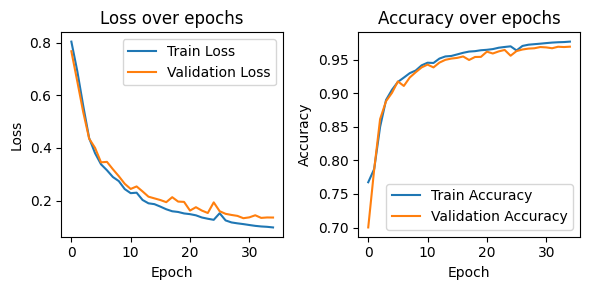

In [7]:
plot_training_history(history_256B32F32)

In [57]:
optimal_threshold_256B32F16, f1_scores_256B32F16 = find_optimal_threshold(model_256B32F16, test_images, test_masks,np.arange(0.1, 0.91, 0.02))
optimal_threshold_256B32F32, f1_scores_256B32F32 = find_optimal_threshold(model_256B32F32, test_images, test_masks,np.arange(0.1, 0.91, 0.02))

8/8 [==============================] - 18s 2s/step


In [58]:
print(optimal_threshold_256B32F16)
print(optimal_threshold_256B32F32)

0.7200000000000001
0.4


1/1 [==============================] - 0s 104ms/step
F1-score model_256B32F16 : 0.9049187302589417
F1-score model_256B32F32 : 0.9054526090621948


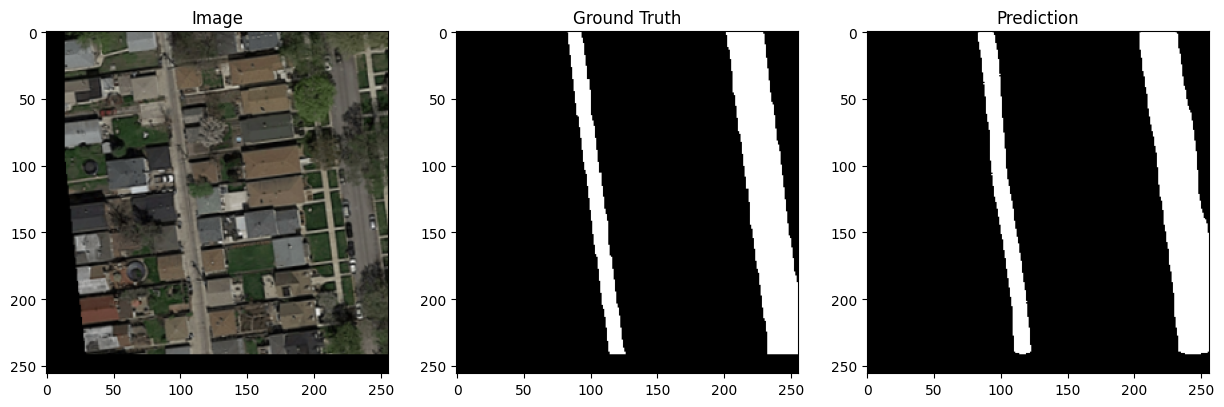

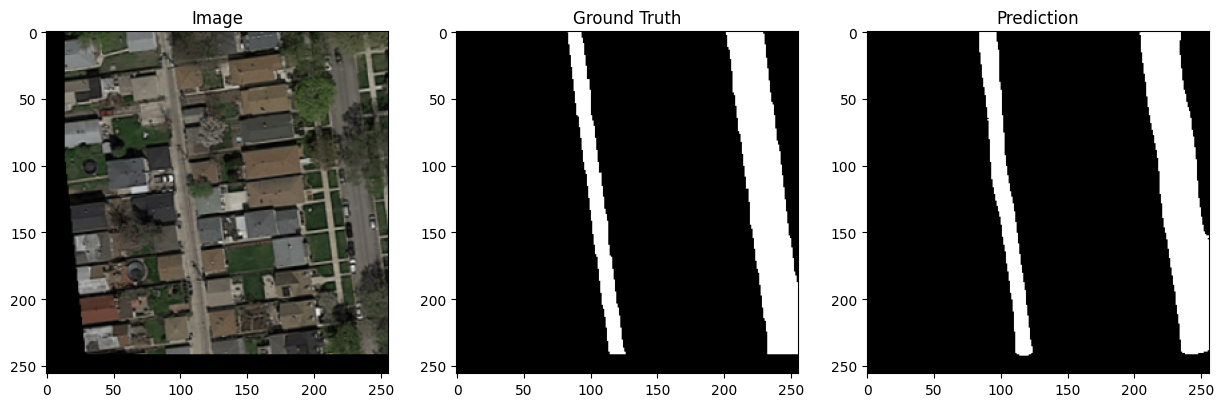

In [68]:
new_image = test_images[11]  
new_mask = test_masks[11]    

pred_bin_256B32F16 = predict_on_image(model_256B32F16, new_image, optimal_threshold_256B32F16)
pred_bin_256B32F32 = predict_on_image(model_256B32F32, new_image, optimal_threshold_256B32F32)

f1_256B32F16 = calculate_f1_on_image(pred_bin_256B32F16, new_mask)
f1_256B32F32 = calculate_f1_on_image(pred_bin_256B32F32, new_mask)
print(f"F1-score model_256B32F16 : {f1_256B32F16}")
print(f"F1-score model_256B32F32 : {f1_256B32F32}")
visualize_prediction(new_image, new_mask, pred_bin_256B32F16)
visualize_prediction(new_image, new_mask, pred_bin_256B32F32)

In [37]:
def calculate_f1_on_set(model, test_images, test_masks, threshold=0.5):
    """
    Calculate the average F1-score on the test set, including empty masks.

    Args:
        model: Trained model.
        test_images: Numpy array of test images (shape: N, H, W, C).
        test_masks: Numpy array of ground truth masks (shape: N, H, W).
        threshold: Threshold to binarize predictions.

    Returns:
        average_f1: Average F1-score over the test set.
    """
    all_f1_scores = []

    for img, true_mask in zip(test_images, test_masks):
        # Expand dimensions for prediction
        img_input = np.expand_dims(img, axis=0)
        
        # Model prediction
        pred_mask = model.predict(img_input, verbose=0)[0, :, :, 0]
        
        # Binarize prediction
        pred_mask_bin = (pred_mask >= threshold).astype(np.uint8)
        
        # Flatten masks
        true_mask_flat = true_mask.flatten()
        pred_mask_bin_flat = pred_mask_bin.flatten()
        
        # Calculate F1-score, including zero_division for empty masks
        f1 = f1_score(true_mask_flat, pred_mask_bin_flat, zero_division=1)
        all_f1_scores.append(f1)

    # Compute average F1-score
    average_f1 = np.mean(all_f1_scores) if all_f1_scores else 0.0
    print(f"Average F1-score on set: {average_f1:.4f}")
    return average_f1

In [ ]:
print ("Model 256B32F16")
print("Train set")
average_f1_256B32F16 = calculate_f1_on_set(model_256B32F16, train_images, train_masks, threshold=optimal_threshold_256B32F16)
print("___________________________")
print("Val set")
average_f1_256B32F16 = calculate_f1_on_set(model_256B32F16, val_images, val_masks, threshold=optimal_threshold_256B32F16)
print("___________________________")
print("Test set")
average_f1_256B32F16 = calculate_f1_on_set(model_256B32F16, test_images, test_masks, threshold=optimal_threshold_256B32F16)
print("___________________________")
print("Model 256B32F32")
print("Train set")
average_f1_256B32F32 = calculate_f1_on_set(model_256B32F32, train_images, train_masks, threshold=optimal_threshold_256B32F32)
print("___________________________")
print("Val set")
average_f1_256B32F32 = calculate_f1_on_set(model_256B32F32, val_images, val_masks, threshold=optimal_threshold_256B32F32)
print("___________________________")
print("Test set")
average_f1_256B32F32 = calculate_f1_on_set(model_256B32F32, test_images, test_masks, threshold=optimal_threshold_256B32F32)
print("___________________________")



Model 256B32F16
Train set
Average F1-score on set: 0.9126
___________________________
Val set
Average F1-score on set: 0.8683
___________________________
Test set
Average F1-score on set: 0.8680
___________________________
Model 256B32F32
Train set
Average F1-score on set: 0.9341
___________________________
Val set
Average F1-score on set: 0.8891
___________________________
Test set
Average F1-score on set: 0.8991
___________________________


[0, 176, 352]


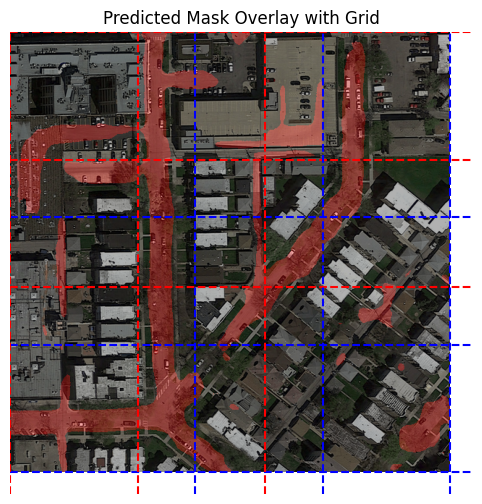

In [34]:
# Load a new 608x608x3 image
new_image = plt.imread("/Users/aurelien/ML/ML_course-main/projects/project2/data/test_set_images/test_4/test_4.png")[:608, :608, :]

# Make a prediction on the image
predicted_mask = predict_on_large_image(model_256B32F32, new_image, optimal_threshold_256B32F32, patch_size=256)

# Extract patches to get coordinates (for visualization only)
_, patch_coords = extract_patches_from_large_image(new_image, patch_size=256)

# Visualize the prediction overlay with grid
visualize_prediction_with_overlay(new_image, predicted_mask, patch_coords, patch_size=256)

In [ ]:
#########################################
# Hyperparamètres
#########################################
input_shape = train_images.shape[1:]  # Dynamically get input shape
lr = 1e-4
patience = 10
batch = 32
n_layers = 6
epochs = 100
init_filters = 64
reg = 1e-6
d_out=0.1

model_256B32F64 = build_unet(input_shape=input_shape,num_layers=n_layers,initial_filters=init_filters,dropout_rate=d_out,l2_reg=reg)

# Compile the model
model_256B32F64.compile(optimizer=Adam(learning_rate=lr), 
              loss=combined_loss,
              metrics=["accuracy"])

# Summary
model_256B32F64.summary()

# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "model_256B32F64.h5", save_best_only=True, monitor="val_loss", mode="min"
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=patience, restore_best_weights=True, monitor="val_loss", mode="min"
)

history_256B32F64 = model_256B32F64.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=epochs,
    batch_size=batch,
    callbacks=[checkpoint_cb, earlystop_cb]
)
#Save the model
model_256B32F64.save("model_256B32F64.h5")